# 🛠️ Working on a larger example w/ Multiclass Classification

> The dataset will not be included in this repo for this example due to size contraints, please download and unzip from links provided in the above table

For this demo we are going to use the fashion mnist dataset

| Name  | Content | Examples | Size | Link | MD5 Checksum|
| --- | --- |--- | --- |--- |--- |
| `train-images-idx3-ubyte.gz`  | training set images  | 60,000|26 MBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz)|`8d4fb7e6c68d591d4c3dfef9ec88bf0d`|
| `train-labels-idx1-ubyte.gz`  | training set labels  |60,000|29 KBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz)|`25c81989df183df01b3e8a0aad5dffbe`|
| `t10k-images-idx3-ubyte.gz`  | test set images  | 10,000|4.3 MBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz)|`bef4ecab320f06d8554ea6380940ec79`|
| `t10k-labels-idx1-ubyte.gz`  | test set labels  | 10,000| 5.1 KBytes | [Download](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz)|`bb300cfdad3c16e7a12a480ee83cd310`|


> [Ubyte files](https://stackoverflow.com/questions/40427435/extract-images-from-idx3-ubyte-file-or-gzip-via-python)
> Unzip these files and place in ./datasets

![Dataset Visual](./assets/embedding.gif)


In [24]:
import itertools
import random


import matplotlib.pyplot as plt
from mnist import MNIST
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import tensorflow as tf

mndata = MNIST('datasets')

train_data_og, train_labels_og = mndata.load_training()
train_data = np.array(train_data_og)
train_labels = np.array(train_labels_og)
test_data_og, test_labels_og = mndata.load_testing()
test_data = np.array(test_data_og)
test_labels = np.array(test_labels_og)

## Visualize
### Labels
Each training and test example is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [3]:
# Show the first training example

print(f"Training sample:\n{train_data[0]}\n")
print(f"Training label:\n{train_labels[0]}\n")

Training sample:
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   1   0   0  13  73   0   0   1   4   0   0   0
   0   1   1   0   0   0   0   0   0   0   0   0   0   0   0   0   3   0
  36 136 127  62  54   0   0   0   1   3   4   0   0   3   0   0   0   0
   0   0   0   0   0   0   0   0   6   0 102 204 176 134 144 123  23   0
   0   0   0  12  10   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 155 236 207 178 107 156 161 109  64  23  77 130  72  15   0   0
   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216 216 163
 127 121 122 146 141  88 172  66   0   0   0   0   0   0   0   0   0   1
   1   1   0 200 232 232 233 229 2

In [4]:
train_data[0].shape, train_labels[0].shape

((784,), ())

In [5]:
# Create a list to index onto our training labels so they're human readable

class_names = ["T-Shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

3


Text(0.5, 1.0, 'Dress')

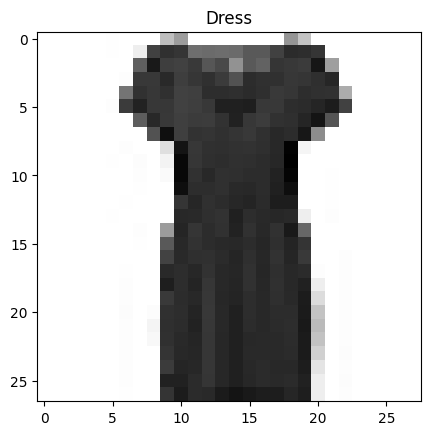

In [6]:
def separate_rows(im_arr, lim=28):
    ret_arr = []
    curr_arr = []
    for i in im_arr:
        if len(curr_arr) == lim:
            ret_arr.append(curr_arr)
            curr_arr = []
            curr_arr.append(i)
            continue
        curr_arr.append(i)
        continue
    return(np.array(ret_arr))

check_idx = 20
print(train_labels[check_idx])
plt.imshow(separate_rows(train_data[check_idx]), cmap=plt.cm.binary)
plt.title(class_names[train_labels[check_idx]])

### Let's plot a few to get a better scope

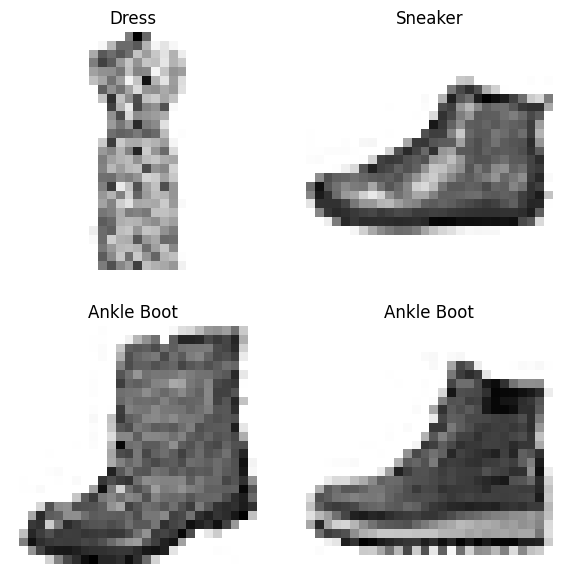

In [7]:
plt.figure(figsize=(7,7))

for i in range(4):
    ax = plt.subplot(2,2,i+1)
    rand_idx = random.choice(range(len(train_data)))
    plt.imshow(separate_rows(train_data[rand_idx]), cmap=plt.cm.binary)
    plt.title(class_names[train_labels[rand_idx]])
    plt.axis(False)

## Build a multi-class classification model

For our multi=class classification model, we can use a similar architecture to our binary classifiers, however, we're going to have to tweak a few things:
* Input Shape = (28, 28) or (784,)
* Output Shape = 10 (one per class of clothing)
* ```
  Loss Function = tf.keras.losses.CategoricalCrossentropy() => One Hot Encoded 
                = tf.keras.losses.SparseCategoricalCrossentropy() => Integers

* Output Layer Activation = SoftMax (not sigmoid)

In [8]:
# Setup tensors
train_data = tf.constant(train_data, dtype=tf.float32)
train_labels = tf.constant(train_labels, dtype=tf.float32)
test_data = tf.constant(test_data, dtype=tf.float32)
test_labels = tf.constant(test_labels, dtype=tf.float32)

# Set random seed (For certain degree of reproducability)
tf.random.set_seed(42)

# Create model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

# Compile model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit model
history = model.fit(train_data, train_labels, epochs=10, validation_data=(test_data, test_labels))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 2.3841 - accuracy: 0.1218 - val_loss: 2.2240 - val_accuracy: 0.1355
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 2.2010 - accuracy: 0.1468 - val_loss: 2.1724 - val_accuracy: 0.1552
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 2.1667 - accuracy: 0.1598 - val_loss: 2.1343 - val_accuracy: 0.1672
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.9554 - accuracy: 0.2354 - val_loss: 1.7362 - val_accuracy: 0.3104
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.7003 - accuracy: 0.3099 - val_loss: 1.6565 - val_accuracy: 0.3116
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.6299 - accuracy: 0.3334 - val_loss: 1.6035 - val_accuracy: 0.3457
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 1.5988 - accuracy: 0.3438 - val_loss: 1.5460 - val_accuracy:

## Tweak to optimize 

Neural networks prefer data to be scaled (or normalized), this means they like to have the numbers in the tensors they try to find patterns between 0 & 1.

In [9]:
# So, dividing by max val (255)

train_data_norm = train_data / 255
test_data_norm = test_data / 255

In [10]:
# Set random seed (For certain degree of reproducability)
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

# Compile model
model_2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit model
history_norm = model_2.fit(train_data_norm, train_labels, epochs=10, validation_data=(test_data_norm, test_labels))

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 1.2816 - accuracy: 0.5647 - val_loss: 0.8933 - val_accuracy: 0.6952
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7745 - accuracy: 0.7195 - val_loss: 0.7113 - val_accuracy: 0.7295
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6604 - accuracy: 0.7495 - val_loss: 0.6702 - val_accuracy: 0.7398
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6298 - accuracy: 0.7612 - val_loss: 0.6505 - val_accuracy: 0.7566
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.6095 - accuracy: 0.7701 - val_loss: 0.6483 - val_accuracy: 0.7632
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5948 - accuracy: 0.7773 - val_loss: 0.6229 - val_accuracy: 0.7709
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.5830 - accuracy: 0.7826 - val_loss: 0.6377 - val_accuracy:

> **🔑 Note:** Just normalization has led to an increase of 15%!

<Axes: title={'center': 'Non-normalized data.'}>

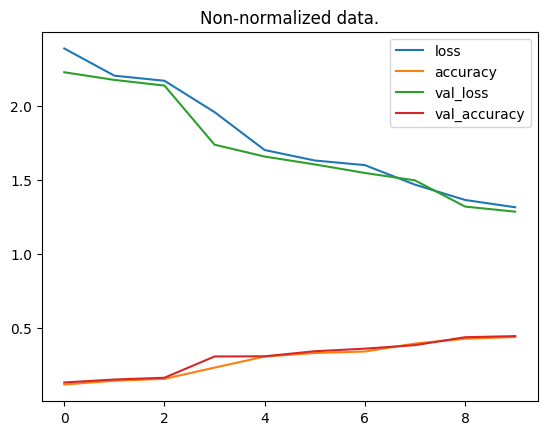

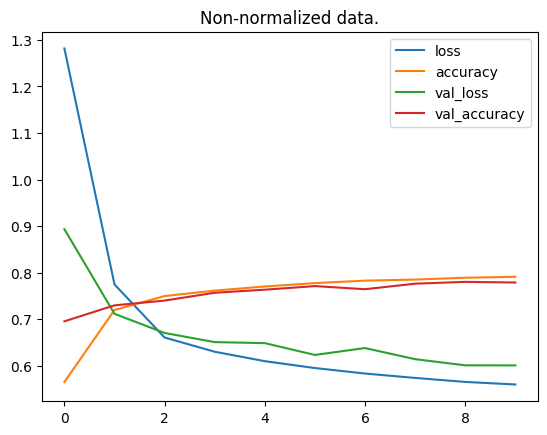

In [11]:
# Plot non normalized data loss curves
pd.DataFrame(history.history).plot(title="Non-normalized data.")
# Plot normalized data loss curves
pd.DataFrame(history_norm.history).plot(title="Non-normalized data.")

> **🔑 Note:** The same model with even *slightly* different data can produce *dramatically* different results. So when you're comparing models, it's importnat to make sure you're comparing them on the same criteria (e.g. same architecture but different data or same data but different architecture)

## Find the ideal Learning Rate

In [12]:
# Set random seed (For certain degree of reproducability)
tf.random.set_seed(42)

# Create model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

# Compile model
model_3.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Create the learning rate callback

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * 10 ** (epoch/20))

# Fit model
history_3 = model_3.fit(train_data_norm, train_labels, epochs=40, validation_data=(test_data_norm, test_labels), callbacks=[lr_scheduler])

Epoch 1/40
1875/1875 [==============================] - 3s 1ms/step - loss: 1.3304 - accuracy: 0.4757 - val_loss: 1.0500 - val_accuracy: 0.5943 - lr: 0.0010
Epoch 2/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.9017 - accuracy: 0.6788 - val_loss: 0.8288 - val_accuracy: 0.7226 - lr: 0.0011
Epoch 3/40
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7731 - accuracy: 0.7312 - val_loss: 0.7657 - val_accuracy: 0.7261 - lr: 0.0013
Epoch 4/40
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7143 - accuracy: 0.7508 - val_loss: 0.7111 - val_accuracy: 0.7624 - lr: 0.0014
Epoch 5/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6681 - accuracy: 0.7681 - val_loss: 0.6970 - val_accuracy: 0.7648 - lr: 0.0016
Epoch 6/40
1875/1875 [==============================] - 3s 2ms/step - loss: 0.6452 - accuracy: 0.7756 - val_loss: 0.6772 - val_accuracy: 0.7738 - lr: 0.0018
Epoch 7/40
1875/1875 [==============================] - 3s

### Plot the learning rate decay curve

Text(0.5, 1.0, 'Finding the ideal Learning Rate')

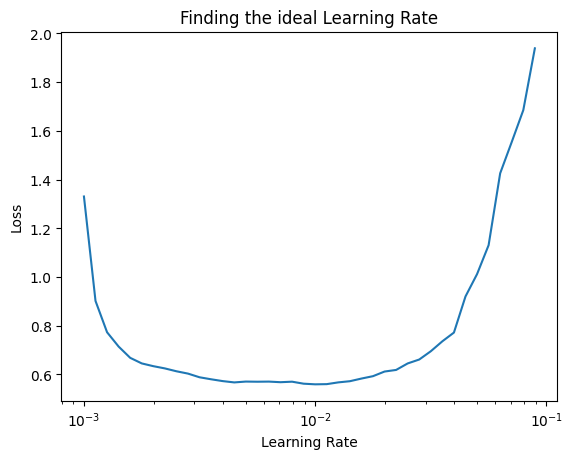

In [13]:
lrs = 1e-3 * (10**(tf.range(40)/20))

plt.semilogx(lrs, history_3.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Finding the ideal Learning Rate")

> **📝 Adam Default lr:** So, with this it's pretty clear that Adam's default learning rate is pretty good.

In [14]:
# Set random seed (For certain degree of reproducability)
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(4, activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(10, activation=tf.keras.activations.softmax)
])

# Compile model
model_4.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

# Fit model
history_4 = model_4.fit(train_data_norm, train_labels, epochs=20, validation_data=(test_data_norm, test_labels))

Epoch 1/20
1875/1875 [==============================] - 3s 1ms/step - loss: 1.2038 - accuracy: 0.5476 - val_loss: 0.8342 - val_accuracy: 0.6913
Epoch 2/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.7258 - accuracy: 0.7424 - val_loss: 0.6986 - val_accuracy: 0.7639
Epoch 3/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6407 - accuracy: 0.7852 - val_loss: 0.6378 - val_accuracy: 0.7889
Epoch 4/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.6036 - accuracy: 0.7985 - val_loss: 0.6246 - val_accuracy: 0.7901
Epoch 5/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5845 - accuracy: 0.8010 - val_loss: 0.6013 - val_accuracy: 0.7943
Epoch 6/20
1875/1875 [==============================] - 2s 1ms/step - loss: 0.5698 - accuracy: 0.8049 - val_loss: 0.6126 - val_accuracy: 0.7932
Epoch 7/20
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5637 - accuracy: 0.8068 - val_loss: 0.6082 - val_accuracy:

## Next steps

We could:
* Evaluate it's performance using other classification metrics
* Assess some of it's predictions (through visualizations)
* Improve it's results (by training it for longer or changing the arch.)
* Save and export it for use in an application

In [15]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10,10), text_size=15):
    """
    Returns a styled colorized confusion matrix with labels
    """
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1) [:, np.newaxis] # normalize our confusion matrix
    n_classes = cm.shape[0]

    # Prettify it
    fig, ax = plt.subplots(figsize=figsize)

    # Create a matrix plot 
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Set labels to be classes
    if classes:
        labels = classes
    else: 
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel = "Predicted Label",
        ylabel = "True Label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )   

    # Set x-axis labels to the bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.yaxis.label.set_size(text_size)
    ax.xaxis.label.set_size(text_size)
    ax.title.set_size(text_size)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) /2

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]} ({cm_norm[i,j]*100:.1f}%)", horizontalalignment="center", color="white" if cm[i,j] > threshold else "black", size=text_size)

> **🔑 Note:** Remember to make your predictions on the same kind of data that the model was trained on (e.g. if your model was trained on normalized data, use normalized data)

In [16]:
y_probs = model_4.predict(test_data_norm) # probs is short for prediction probabilities

# Convert all of the prediction probabilities into integers 
y_preds = y_probs.argmax(axis=1)

# View the first 10 prediction labels
y_preds[:10]

313/313 [==============================] - 0s 765us/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=int64)

In [17]:
confusion_matrix(test_labels, y_preds)

array([[677,   2,  22, 170,   6,   1, 111,   0,  11,   0],
       [  0, 938,  11,  44,   4,   0,   3,   0,   0,   0],
       [ 13,   6, 622,  27, 237,   0,  95,   0,   0,   0],
       [ 20,  47,  23, 831,  39,   1,  33,   1,   5,   0],
       [  0,   7,  82,  30, 824,   0,  51,   0,   6,   0],
       [  0,   0,   0,   5,   1, 899,   0,  39,  17,  39],
       [116,   1,  98, 104, 216,   0, 450,   0,  15,   0],
       [  0,   0,   0,   0,   0,  62,   0, 888,   1,  49],
       [  2,   0,   1,  12,  10,  10,  50,   7, 908,   0],
       [  0,   0,   0,   0,   0,  41,   0,  45,   1, 913]], dtype=int64)

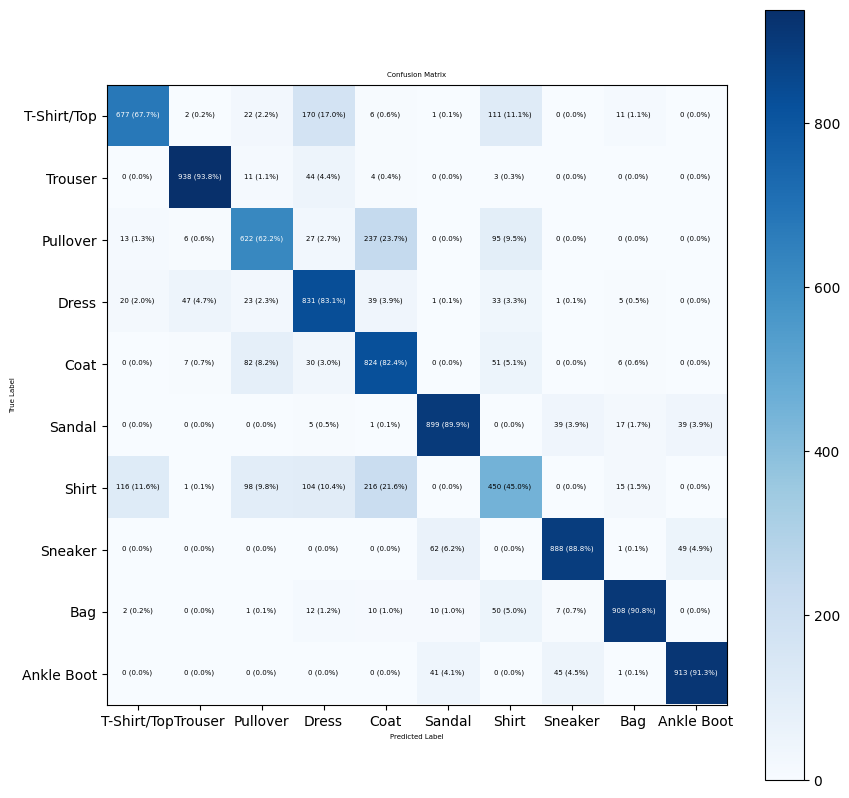

In [18]:
# Make our confusion matrix
make_confusion_matrix(
    test_labels,
    y_preds,
    class_names,
    figsize=(10,10),
    text_size=5
)

In [19]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 4)                 3140      
                                                                 
 dense_10 (Dense)            (None, 4)                 20        
                                                                 
 dense_11 (Dense)            (None, 10)                50        
                                                                 
Total params: 3,210
Trainable params: 3,210
Non-trainable params: 0
_________________________________________________________________


> **🔑 Note:** Often when working with images and other forms of visual data, it's a good idea to visualize as much as possible to develop a further understanding of the data and the inputs and outputs of your models.

Let's create functions for: 
* Plot a random image
* Make a prediction on said iamge
* Label the plot with the truth label and the predicted label

In [27]:
def plot_random_image(model, images, true_labels, classes):
    """
    Picks a random image, plots it and labels it with a prediction and truth label.
    """

    i = random.randint(0, len(images))

    # Create prediction and target 
    target_image = images[i]
    pred_probs = model.predict(tf.constant(np.array([target_image]), dtype=tf.float32))
    pred_label = classes[pred_probs.argmax()]
    true_label = classes[true_labels[i]]

    # Plot the image
    plt.imshow(separate_rows(target_image), cmap=plt.cm.binary)

    # Change the color of the titles depending on if the prediction is right or wrong 
    if pred_label == true_label:
        color = "green"
    else: 
        color = "red"

    # Add xlabel information (prediction/true label)
    plt.title("Pred: {} {:2.0f}% (True: {})".format(
        pred_label,
        100*tf.reduce_max(pred_probs),
        true_label
    ), color = color)
    plt.axis(False)

1/1 [==============================] - 0s 23ms/step


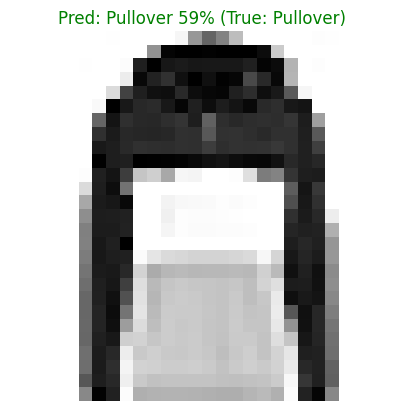

In [28]:
# Check out a random image as well as it's prediction
plot_random_image(model_4, test_data_norm, test_labels_og, class_names)

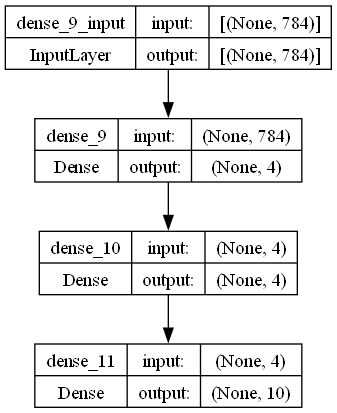

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model_4, show_shapes=True)